<b><font color="F37321" size="6px">
    Hanwha General Insurance
</font></b>

<b><font color="654321" size="5px">
    Mask R-CNN
</font></b>

---

# Definition

## Import

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

In [2]:
import cv2
import sys
from datetime import datetime
import pickle
import random
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from glob import glob

In [3]:
# %matplotlib inline 

In [4]:
sys.path.append("Mobile_Mask_RCNN/")

# Import Mobile Mask R-CNN Packages
from mmrcnn.config import Config
from mmrcnn import model as modellib, utils,visualize
from mmrcnn.model import log

# Directory to save logs and trained model
MODEL_DIR = "ckpt/mobilenetv2_initial"

from mrcnn import simdotation as annotation

Using TensorFlow backend.


## Configurations

In [5]:
# sys.path.append("./")
from configs.mobilenetv2_config1 import CarConfig

config = CarConfig()
config.display()


Configurations:
BACKBONE                       mobilenetv2
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]

## Dataset

In [6]:
class TYDataset(utils.Dataset):
    def date_list(self, dataset, flip, rotation, bright):

        from glob import glob
        from tqdm import tqdm
        idx = 0
        
        # Add classes
        for name in list(sorted(annotation.MASK_CLS_DICT.keys())):
            cls = annotation.MASK_CLS_DICT[name]
            self.add_class("car", int(cls) + 1, str(name))
        
        for lr in flip:
            
            for rt in rotation:
                
                for br in bright:

                    for info in tqdm(dataset):

                        try:

                            IMAGEPATH, MASKPATH, SHAPE, COORDINATE = info

                            for coor in COORDINATE:

                                self.add_image(
                                    source="car",
                                    image_id=idx,
                                    path=IMAGEPATH,
                                    masks_path=[MASKPATH],
                                    flip=lr,
                                    crop=coor,
                                    angle=rt,
                                    brightness=br,
                                )
                                idx += 1

                        except:

                            pass
                        
    def load_image(self, image_id):

        path = self.image_info[image_id]["path"]
        flip = self.image_info[image_id]["flip"]
        crop = self.image_info[image_id]["crop"]
        angle = self.image_info[image_id]["angle"]
        brightness = self.image_info[image_id]["brightness"]

        return annotation.image_gbr_to_rgb(path, flip, crop, angle, brightness)

    def load_mask(self, image_id):

        path = self.image_info[image_id]["masks_path"]
        flip = self.image_info[image_id]["flip"]
        crop = self.image_info[image_id]["crop"]
        angle = self.image_info[image_id]["angle"]

        mask, cls = annotation.mask_path_list(path, flip, crop, angle)

        return mask, cls.astype(np.int32)

### create dataset

In [7]:
with open('../kidi_data/damage_class_mask/train/pickles/train_190701.p', 'rb') as p:
    traindataset = pickle.load(p)

with open('../kidi_data/damage_class_mask/eval/pickles/eval_190701.p', 'rb') as p:
    testdataset = pickle.load(p)

In [8]:
traindataset[2]

['../kidi_data/damage_class_mask/train/images/000001352.jpg',
 '../kidi_data/damage_class_mask/train/annotations/000001352.png',
 (600, 800, 3),
 [[0, 600, 0, 800]]]

In [9]:
dataset_val = TYDataset()
dataset_val.date_list(
    dataset=testdataset,
    flip=[False],
    rotation = [0],
    bright = [1],
)
dataset_val.prepare()

100%|██████████| 1648/1648 [00:00<00:00, 345282.63it/s]


In [10]:
config.VALIDATION_STEPS = len(dataset_val.image_ids) // config.BATCH_SIZE
# config.VALIDATION_STEPS = 5
print(config.VALIDATION_STEPS)

206


### <b><font color="123456"> Vis. Dataset </font></b></h3>

1381


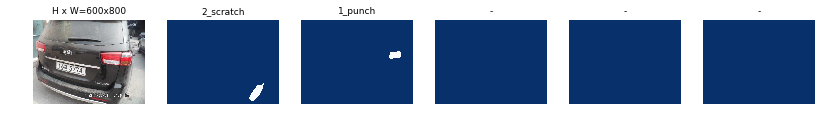

855


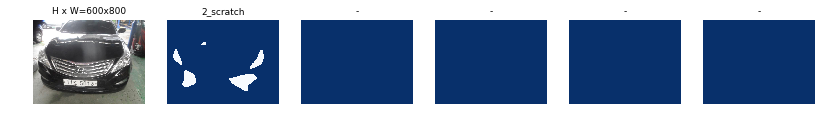

665


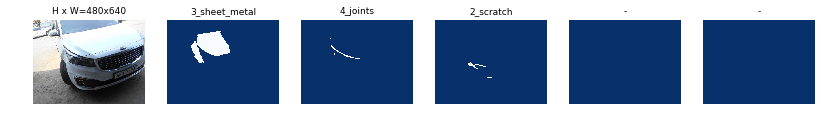

854


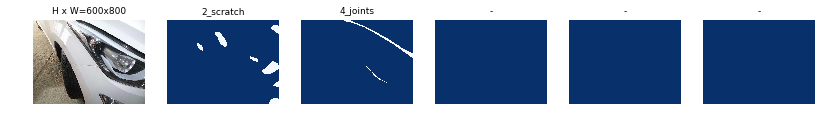

522


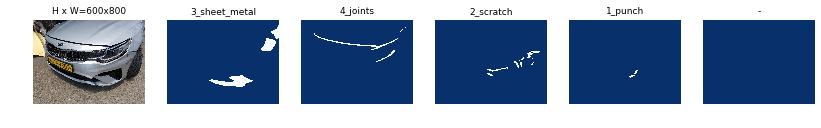

In [11]:
image_ids = np.random.choice(dataset_val.image_ids, 5, replace=False)

for image_id in image_ids:

    print(image_id)

    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids,
                                dataset_val.class_names, 5)

In [12]:
# dataset_train = TYDataset()
# dataset_train.date_list(
#     dataset=traindataset,
#     flip=[False, True],
#     bright=[1],
#     rotation=[0]
# #     bright=[2/3, 3/2], 
# #     rotation = [-16, -8, 8, 16],
# )
# dataset_train.prepare()

In [13]:
dataset_train = TYDataset()
dataset_train.date_list(
    dataset=traindataset,
    flip=[False, True],
    bright = [4/5, 1, 5/4],
    rotation = [0],
)
dataset_train.prepare()

100%|██████████| 14179/14179 [00:00<00:00, 175471.16it/s]


In [14]:
IPE = 10

In [15]:
config.STEPS_PER_EPOCH = len(dataset_train.image_ids) // (CarConfig.IMAGES_PER_GPU * CarConfig.GPU_COUNT)
# config.STEPS_PER_EPOCH = 3
print(config.STEPS_PER_EPOCH)

30198


### <b><font color="123456"> Vis. Dataset </font></b></h3>

205290


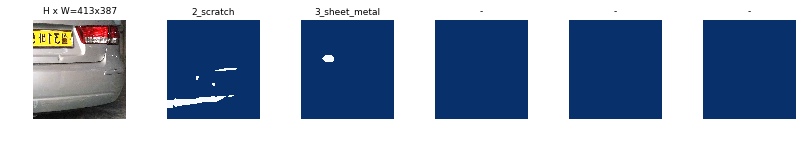

210801


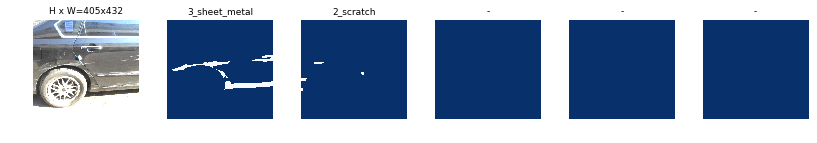

140326


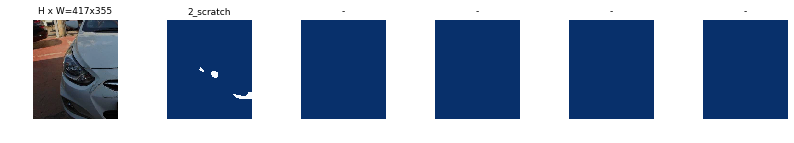

85252


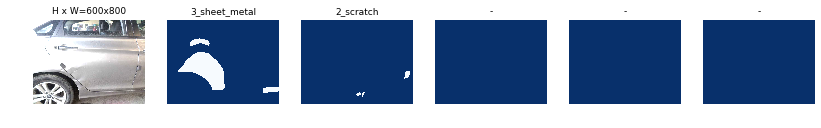

116920


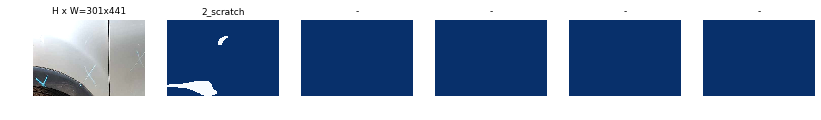

181605


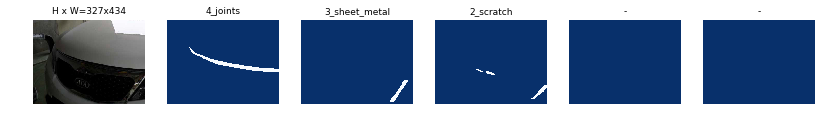

133079


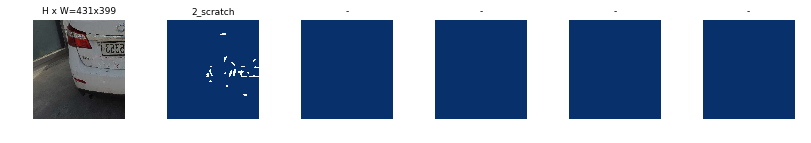

142772


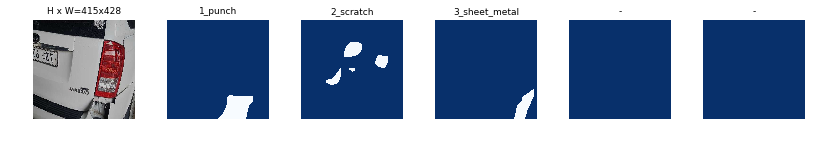

162812


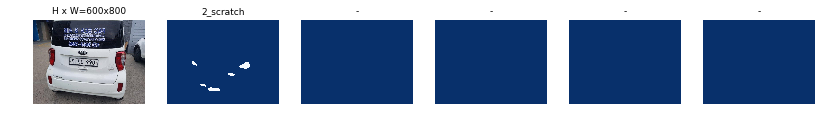

63699


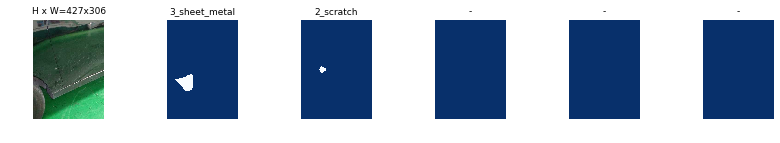

In [ ]:
image_ids = np.random.choice(dataset_train.image_ids, 10, replace=False)

for image_id in image_ids:

    print(image_id)

    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids,
                                dataset_train.class_names, 5)

## Bounding Boxes

image_id  54307 
image                    shape: (445, 343, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (445, 343, 4)         min:    0.00000  max:  255.00000  uint8
class_ids                shape: (4,)                  min:    2.00000  max:    2.00000  int32
bbox                     shape: (4, 4)                min:   28.00000  max:  445.00000  int32


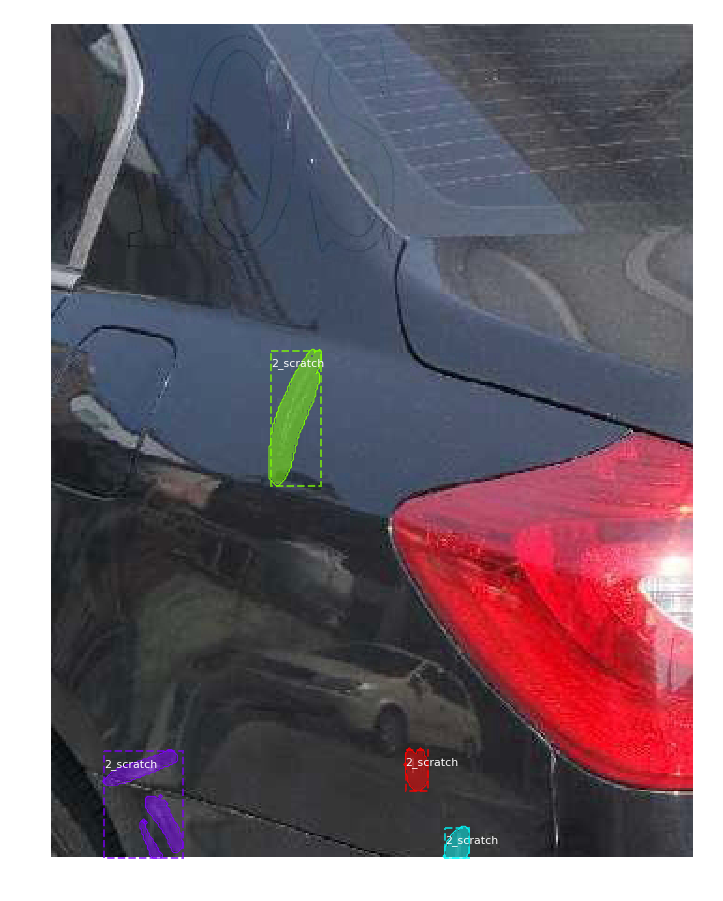

In [ ]:
# Load random image and mask.
image_id = random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset_train.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids,
                            dataset_train.class_names)

## Resize Images

image_id:  53209 
Original shape:  (411, 425, 3)
image                    shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (512, 512, 3)         min:    0.00000  max:  255.00000  uint8
class_ids                shape: (3,)                  min:    2.00000  max:    2.00000  int32
bbox                     shape: (3, 4)                min:  241.00000  max:  446.00000  int32


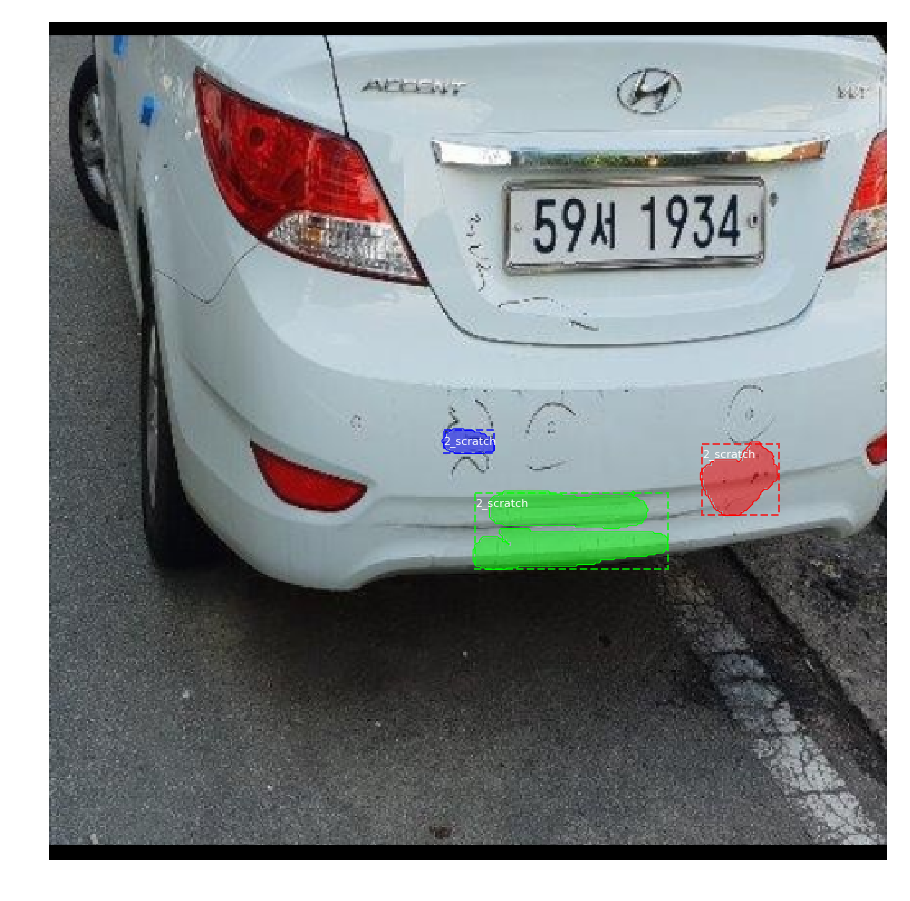

In [ ]:
# Load random image and mask.
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
original_shape = image.shape

# Resize
image, window, scale, padding, crop = utils.resize_image(
    image,
    min_dim=config.IMAGE_MIN_DIM,
    max_dim=config.IMAGE_MAX_DIM,
    min_scale=config.IMAGE_MIN_SCALE,
    mode=config.IMAGE_RESIZE_MODE)
mask = utils.resize_mask(mask, scale, padding, crop)

# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset_train.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids,
                            dataset_train.class_names)

## Anchors

In [ ]:
# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(
    config.RPN_ANCHOR_SCALES,
    config.RPN_ANCHOR_RATIOS,
    backbone_shapes,
    config.BACKBONE_STRIDES,
    config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
anchors_per_cell = 3
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  65472
Scales:  (16.0, 32.0, 48.0, 80.0, 160.0)
ratios:  [0.9559555894070776, 1.52, 2.5]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 49152
Anchors in Level 1: 12288
Anchors in Level 2: 3072
Anchors in Level 3: 768
Anchors in Level 4: 192


Level 0. Anchors:  49152  Feature map Shape: [128 128]
Level 1. Anchors:  12288  Feature map Shape: [64 64]
Level 2. Anchors:   3072  Feature map Shape: [32 32]
Level 3. Anchors:    768  Feature map Shape: [16 16]
Level 4. Anchors:    192  Feature map Shape: [8 8]


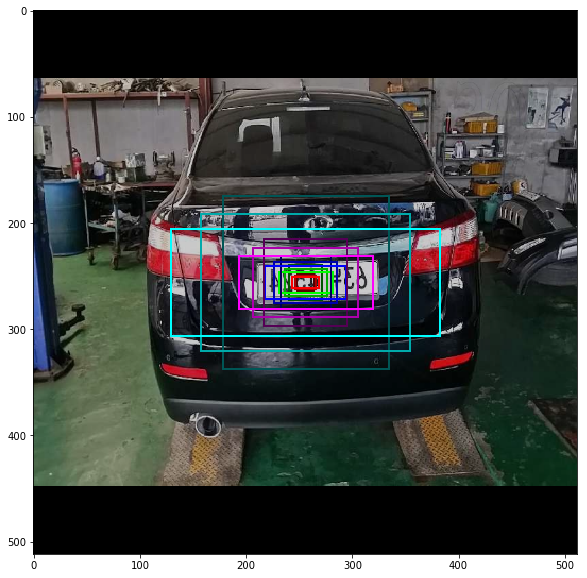

In [ ]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset_train.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset_train, 
                                                    config,
                                                    image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    
    colors = visualize.random_colors(levels)
    colors = [(1.0, 0.0, 0.0),
              (0.0, 1.0, 0.0),
              (0.0, 0.0, 1.0),
              (1.0, 0.0, 1.0),
              (0.0, 1.0, 1.0),]
    
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level])  # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start + anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], backbone_shapes[level]))
    
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    
    # level_center = center_cell_index * anchors_per_cell
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) + center_cell[1] / config.RPN_ANCHOR_STRIDE
    )
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center + anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            facecolor='none',
            edgecolor=(i + 1) * np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)

# Training

## Ceate Model

In [ ]:
print(MODEL_DIR)

ckpt/mobilenetv2_initial


In [ ]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [ ]:
# model_path = model.find_last()[1]
# model_path = "Mobile_Mask_RCNN/mobile_mask_rcnn_coco.h5"
model_path = 'ckpt/mobilenetv2_initial/512_mobilenetv2_config120190715T1032/mask_rcnn_512_mobilenetv2_config1_0010.h5'
model_path

'ckpt/mobilenetv2_initial/512_mobilenetv2_config120190715T1032/mask_rcnn_512_mobilenetv2_config1_0010.h5'

In [ ]:
try:
    model.load_weights(model_path, by_name=True)
    
except:
    model.load_weights(model_path, by_name=True, exclude=[
        "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

## Run!

In [ ]:
config.LEARNING_RATE = 1e-3

try:
    model.train(
        dataset_train,
        dataset_val,
        learning_rate=config.LEARNING_RATE,
        epochs=80,
        layers='all', update_freq=10000)

except KeyboardInterrupt:
    print()
    print("(Ctrl + c)")


Starting at epoch 10. LR=0.001

Checkpoint Path: ckpt/mobilenetv2_initial/512_mobilenetv2_config120190719T0932/mask_rcnn_512_mobilenetv2_config1_{epoch:04d}.h5
Selecting layers to train
conv0                  (Conv2D)
conv0_bn               (BatchNorm)
conv1                  (Conv2D)
conv1_bn               (BatchNorm)
conv_dw_1              (DepthwiseConv2D)
conv_dw_1_bn           (BatchNorm)
conv_pw_1              (Conv2D)
conv_pw_1_bn           (BatchNorm)
conv2                  (Conv2D)
conv2_bn               (BatchNorm)
conv_dw_2              (DepthwiseConv2D)
conv_dw_2_bn           (BatchNorm)
conv_pw_2              (Conv2D)
conv_pw_2_bn           (BatchNorm)
conv3                  (Conv2D)
conv3_bn               (BatchNorm)
conv_dw_3              (DepthwiseConv2D)
conv_dw_3_bn           (BatchNorm)
conv_pw_3              (Conv2D)
conv_pw_3_bn           (BatchNorm)
conv4                  (Conv2D)
conv4_bn               (BatchNorm)
conv_dw_4              (DepthwiseConv2D)
conv_dw_

Instructions for updating:
Use tf.cast instead.
/home/kidi/.conda/envs/kidi/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 11/80
30198/30198 [==============================] - 32907s 1s/step - loss: 1.4470 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.3604 - mrcnn_class_loss: 0.2736 - mrcnn_bbox_loss: 0.3585 - mrcnn_mask_loss: 0.4214 - val_loss: 2.0871 - val_rpn_class_loss: 0.0407 - val_rpn_bbox_loss: 0.8665 - val_mrcnn_class_loss: 0.2818 - val_mrcnn_bbox_loss: 0.4684 - val_mrcnn_mask_loss: 0.4297
Epoch 12/80
30198/30198 [==============================] - 32942s 1s/step - loss: 1.4188 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.3479 - mrcnn_class_loss: 0.2665 - mrcnn_bbox_loss: 0.3519 - mrcnn_mask_loss: 0.4198 - val_loss: 2.1299 - val_rpn_class_loss: 0.0412 - val_rpn_bbox_loss: 0.9019 - val_mrcnn_class_loss: 0.2860 - val_mrcnn_bbox_loss: 0.4725 - val_mrcnn_mask_loss: 0.4282
Epoch 13/80
30198/30198 [==============================] - 26611s 881ms/step - loss: 1.3921 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.3368 - mrcnn_class_loss: 0.2593 - mrcnn_bbox_loss: 0.3454 - mrcnn_mask_loss: 0.4184 - val_loss: 

# 끝!